# Описание проекта
Наша задача как маркетингового аналитика развлекательного приложения Procrastinate Pro+, разобраться почему несмотря на огромные вложения в рекламу компания продолжает терпеть убытки, а также найти пути изменения данной ситуации.

Для этого у нас есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Для достижения данной цели мы :
- загрузим данные и подготовим их к анализу
- зададим функции для расчета и анализа LTV, ROI, удержания и конверсии
- проведемисследовательский анализ данных
- разберем маркетинг
- оценим окупаемость рекламы
- подведем итоги и опишем рекомендации для исправления данного положения

Описание данных

В вашем распоряжении три датасета. 
Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
orders_info_short.csv — информацию о покупках, 
а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv

- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv

- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv

- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.

## Шаг 1. Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
#изменим тип данных в столбцах
visits['Region'] = visits['Region'].astype(str)
visits['Device'] = visits['Device'].astype(str)
visits['Channel'] = visits['Channel'].astype(str)

In [6]:
visits.columns = visits.columns.str.lower() #приведем данные к нижнему регистру

In [7]:
visits = visits.rename(columns={"user id": "user_id"})

In [8]:
visits = visits.rename(columns={"session start": "session_start"})

In [9]:
visits = visits.rename(columns={"session end": "session_end"})

In [10]:
visits['user_id'].value_counts() # узнаем количество уникальных пользователей и самого встречающегося

33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
350468480225     1
748123264144     1
909267360937     1
816252757222     1
425788122907     1
Name: user_id, Length: 150008, dtype: int64

In [11]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [12]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [13]:
visits['session_start'].value_counts()

2019-10-01 09:35:59    3
2019-06-27 14:56:41    3
2019-07-12 11:43:00    3
2019-10-15 09:47:57    3
2019-05-19 06:19:20    3
                      ..
2019-08-25 07:35:16    1
2019-05-01 08:48:49    1
2019-05-05 15:13:34    1
2019-05-07 04:46:25    1
2019-07-18 10:16:32    1
Name: session_start, Length: 306813, dtype: int64

In [14]:
visits['session_end'].value_counts() # начатых сессий чуть больше, возможно на момент сбора данных пользователи не завершили сессию

2019-07-05 03:22:47    3
2019-08-04 12:14:49    3
2019-08-03 06:31:26    3
2019-05-20 08:57:51    3
2019-07-16 02:23:30    3
                      ..
2019-05-06 08:49:35    1
2019-05-08 01:02:09    1
2019-10-29 10:43:42    1
2019-06-19 20:26:30    1
2019-09-24 15:46:06    1
Name: session_end, Length: 306793, dtype: int64

In [15]:
# разберем заказы
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [17]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'], format="%Y-%m-%d %H:%M:%S") # поменяем формат с object в datetime

In [18]:
orders.columns = orders.columns.str.lower() # приведем данные к нижнему регистру

In [19]:
orders = orders.rename(columns={"user id": "user_id"})
orders = orders.rename(columns={"event dt": "event_dt"}) # переименуем столбцы

In [20]:
orders['user_id'].value_counts()

901180916748    22
883098437811    20
75337957494     19
512471511263    19
295795879965    19
                ..
237296010927     1
319939546352     1
742075710598     1
202972423389     1
775233404832     1
Name: user_id, Length: 8881, dtype: int64

In [21]:
orders['event_dt'].value_counts()

2019-09-29 09:03:24    2
2019-10-25 16:24:24    2
2019-09-27 03:56:55    2
2019-08-12 22:50:49    2
2019-09-09 20:01:39    2
                      ..
2019-09-26 04:24:10    1
2019-10-26 06:25:45    1
2019-07-10 17:04:38    1
2019-08-06 08:55:42    1
2019-09-25 16:41:33    1
Name: event_dt, Length: 40163, dtype: int64

In [22]:
orders['event_dt'].count() # из 40212 строк 40163 уникальные

40212

In [23]:
orders['revenue'].describe() # можно предположить, что 4.99 это цена подписки, а также маловероятны сильные выбросы

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

In [24]:
costs.info() # разберем затраты на рекламу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [25]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [26]:
costs['Channel'] = costs['Channel'].astype('str')

In [27]:
costs.columns = costs.columns.str.lower()

In [28]:
costs['dt'].value_counts()

2019-09-09    10
2019-06-19    10
2019-05-14    10
2019-07-12    10
2019-09-21    10
              ..
2019-10-18    10
2019-05-04    10
2019-08-02    10
2019-07-07    10
2019-05-05    10
Name: dt, Length: 180, dtype: int64

In [29]:
costs['dt'].count() # всего 1800 строк из них 180 уникальные, следовательно данные за 180 дней

1800

In [30]:
costs['channel'].unique() # 10 источников рекламы

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [31]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

ВЫВОД:
Мы оптимизировали данные для дальнейшего анализа

In [32]:
# проверка на дубликаты
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


In [33]:
orders[orders.duplicated()]

,user_id,event_dt,revenue


In [34]:
costs[costs.duplicated()]

,dt,channel,costs


In [35]:
visits.info() # проверка на пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [36]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [37]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [38]:
visits.isnull().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [39]:
orders.isnull().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [40]:
costs.isnull().sum()

dt         0
channel    0
costs      0
dtype: int64

пропуски и дубликаты не обнаружены

## Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

In [41]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

In [42]:
# функция для расчёта удержания

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False,
):

    # добавляем платящих в список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не вошедших в интервал
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_cm']
    ).dt.days

In [43]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    # задаем пределы таблице динамики
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # строим кривые удержания неплатящих пользователей
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # строим график и фильтруем данные
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # строим график и фильтруем данные
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [44]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # определяем границы анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_cm']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # строим таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    # строим таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [45]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    # определяем границы таблицы динамики
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    #  динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [46]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # определяем границы анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_cm']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем таблицы
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # подсчитываем LTV
        result = result.div(result['cohort_size'], axis=0)
        # определяем границы
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [47]:
# функция для сглаживания фрейма

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [48]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    # оперделяем границы в таблице динамики
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # записываем стоимость привлечения
    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    # определяем границы roi
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Проведите исследовательский анализ данных

3.1. Создадим пользовательские профили. Определим минимальную и максимальную даты привлечения пользователей.

In [49]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_cm'})
        .reset_index()
    )

    # определяем дату и день первого посещения
    profiles['dt'] = profiles['first_cm'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_cm'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # подсчитываем количество уникальных пользователей с одинаковой датой и источником привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [50]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [51]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [52]:
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [53]:
# смотрим профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_cm,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [54]:
# определим интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

In [55]:
print(min_analysis_date, ',' ,observation_date)

2019-05-01 00:00:00 , 2019-10-27 00:00:00


Минимальная дата привлечения пользователей - 1 мая 2019 года. Максимальная дата привлечения пользователей - 27 октября 2019 года

3.2. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [56]:
country_inc = pd.DataFrame()
country_inc['users_cnt'] = profiles.groupby('region')['user_id'].count()
country_inc['share'] = ((country_inc['users_cnt'] / profiles['region'].count()) * 100)
country_inc.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'}) 
#смотрим количество пользователей из каждой страны, а также их долю

,users_cnt,share
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


In [57]:
country_payer_inc = pd.DataFrame()
country_payer_inc['users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
country_payer_inc['share'] = ((country_payer_inc['users_cnt'] / profiles.query('payer == True')['region'].count()) * 100)
country_payer_inc.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})
# Проверяем количество платящих пользователей

,users_cnt,share
region,,
United States,6902,77.72%
UK,700,7.88%
France,663,7.47%
Germany,616,6.94%


In [58]:
# Рассчитаем долю платящих пользователей отдельно по странам.
def region_dol9(column, df):
    result = pd.DataFrame()
    result['users_cnt'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users_cnt'] / df[column].count()) * 100)
    result['payer_users_cnt'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users_cnt'] / result['users_cnt']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.2f}%', 'payer_share': '{:.2f}%'})

In [59]:
region_dol9('region', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


ВЫВОД: видим, что больше всего платящих пользователей в США (6.9%), а меньше всего во Франции (3.8%)

3.3. Узнаем, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи.

In [60]:
device_use = pd.DataFrame()
device_use['users_cnt'] = profiles.groupby('device')['user_id'].count()
device_use['share'] = ((device_use['users_cnt'] / profiles['device'].count()) * 100)
device_use.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


Больше всего пользователей с iphone (36.32%), а меньше всего с Mac (20.03%)

In [61]:
# рассмотрим платящих пользователей
device_use_payers = pd.DataFrame()
device_use_payers['users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_use_payers['share'] = ((device_use_payers['users_cnt'] / profiles.query('payer == True')['device'].count()) * 100)
device_use_payers.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,3382,38.08%
Android,2050,23.08%
Mac,1912,21.53%
PC,1537,17.31%


Большинство платящих также с iphone (38.08%), а меньше всего изменилось на PC (17.31%), при том что разница в количестве пользователей между PC и Mac была всего 0.27%

In [62]:
# Рассчитаем долю платящих пользователей для каждого устройства.
region_dol9('device', profiles)


,users_cnt,users_share,payer_users_cnt,payer_share
device,,,,
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%
Mac,30042,20.03%,1912,6.36%


ВЫВОД: наибольшая доля платящих у Mac (6.36%), а наименьшая у PC (5.05%)

3.4. Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [63]:
reklama_share = pd.DataFrame()
reklama_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
reklama_share['share'] = ((reklama_share['users_cnt'] / profiles['channel'].count()) * 100)

reklama_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
reklama_share['payer_share'] = ((reklama_share['payer_users_cnt'] / profiles.query('payer == True')['channel'].count()) * 100)

reklama_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,users_cnt,share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.62%,1160,13.06%
FaceBoom,29144,19.43%,3557,40.05%
TipTop,19561,13.04%,1878,21.15%
OppleCreativeMedia,8605,5.74%,233,2.62%
LeapBob,8553,5.70%,262,2.95%
WahooNetBanner,8553,5.70%,453,5.10%
RocketSuperAds,4448,2.97%,352,3.96%
MediaTornado,4364,2.91%,156,1.76%
YRabbit,4312,2.87%,165,1.86%


По таблице видно, что:
- Наилучший источник привлечения пользователей это organic (37.62%), после идут FaceBoom (19.43%) и TipTop (13.04%) дальше доли идут примерно равно от 2.5% до 6%, при этом самый худший показатель у lambdaMediaAds (1.43%)
- Наилучший источник для платящих поменялся, это FaceBoom (40.05%), дальше идут TipTop (21.15%), а доля organic уже составляет всего 13.06%, дальше распределение долей приблизительно от 1.5% до 5%,  при этом самый худший показатель у MediaTornado (1.76%)

In [64]:
region_dol9('channel', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.62%,1160,2.06%
FaceBoom,29144,19.43%,3557,12.20%
TipTop,19561,13.04%,1878,9.60%
OppleCreativeMedia,8605,5.74%,233,2.71%
LeapBob,8553,5.70%,262,3.06%
WahooNetBanner,8553,5.70%,453,5.30%
RocketSuperAds,4448,2.97%,352,7.91%
MediaTornado,4364,2.91%,156,3.57%
YRabbit,4312,2.87%,165,3.83%


Большинство платящих пользователей приходится на каналы FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%). Менее всего из канала organic (2.06%)

## Шаг 4. Маркетинг

4.1 Сколько денег потратили? Всего / на каждый источник / по времени

In [65]:
display(costs.sum()) # траты на маркенитг

channel    FaceBoomFaceBoomFaceBoomFaceBoomFaceBoomFaceBo...
costs                                               105497.3
dtype: object

In [66]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


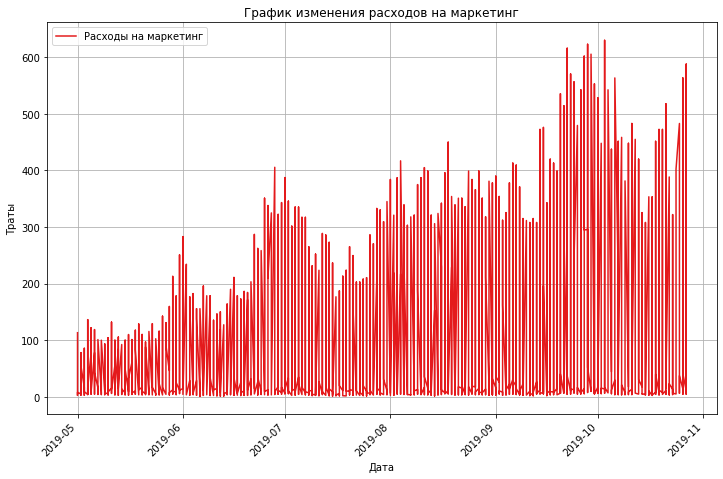

In [67]:
#график расходов на маркетинг
costs.plot(y='costs', 
           x='dt',
           figsize=(12, 8), 
           grid=True, 
           rot=45,        
           label='Расходы на маркетинг',                       
           legend=True,
           colormap='Set1') 

plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

по графику видим, что расходы на маркетинг постепенно растут, в начале октября пик приблизительно в 630 

Выясним, как траты распределены по источникам.

In [68]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [69]:
costs_expenses = pd.DataFrame()
costs_expenses['costs'] = costs.groupby('channel')['costs'].sum()
costs_expenses['share'] = ((costs_expenses['costs'] / costs['costs'].sum()) * 100)
costs_expenses.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,costs,share
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


Больше всего трат на TipTop (51.9%), меньше всего на MediaTornado и YRabbit (по 0.9)

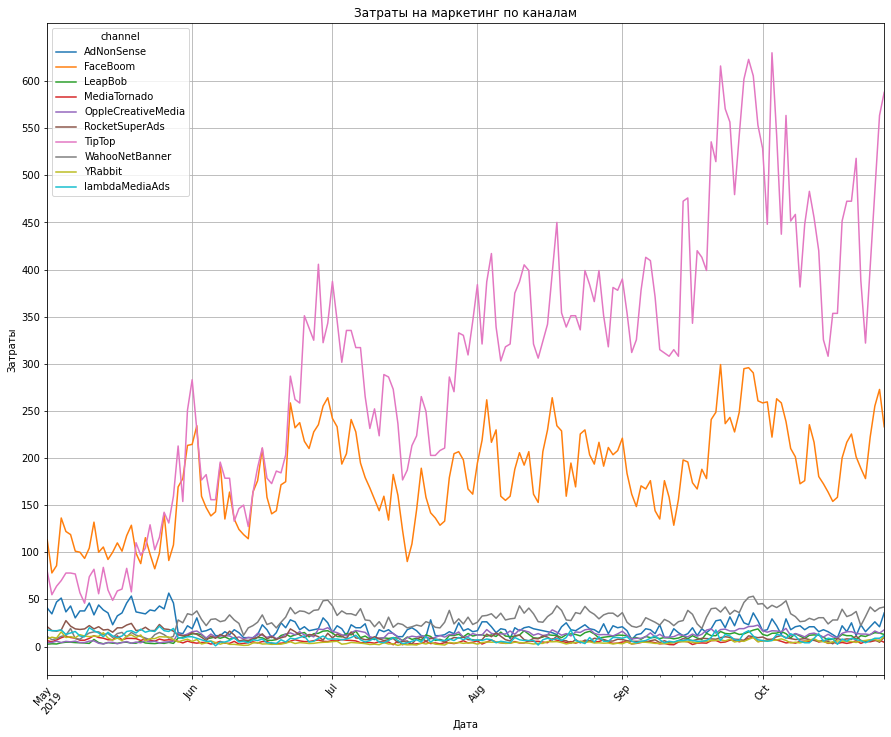

In [70]:
# Визуализируем изменения метрик во времени
pay_piar = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
pay_piar.plot(                                             
           figsize=(15, 12), 
           grid=True, 
           rot=50,        
           label='Каналы',                       
           legend=True,
) 

plt.yticks(np.arange(0, 650, 50)) 
plt.title('Затраты на маркетинг по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

На графике выделяются TipTop и FaceBoom, показатели FaceBoom держаться примерно в диапазоне 150-300 у.е., а показатели TipTop постепенно растут и к началу октября достигают приблизительно 650 у.е.. Для удобного рассмотра других источников, сделаем график без этих двух.

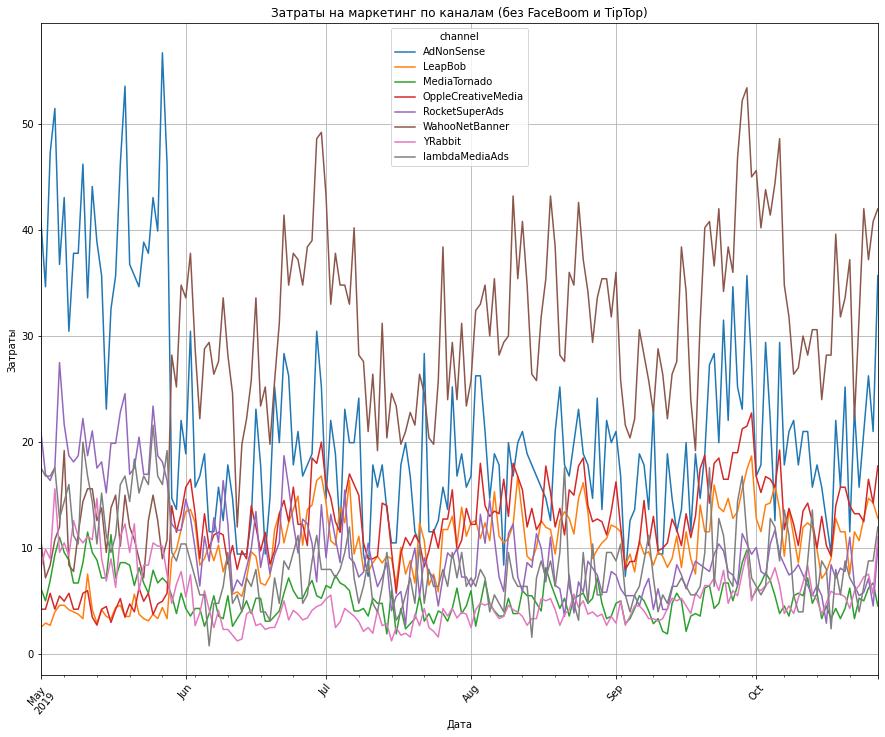

In [71]:
pay_piar2 = costs[~costs['channel'].isin(['TipTop', 'FaceBoom'])].pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )

pay_piar2.plot(                                             
           figsize=(15, 12), 
           grid=True, 
           rot=50,        
           label='Каналы',                        
           legend=True,
) 

plt.yticks(np.arange(0,  60, 10)) 
plt.title('Затраты на маркетинг по каналам (без FaceBoom и TipTop)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

По графику видим, что с июня начали расти траты на WahooNetBanner, а затраты на AdNonSense, наоборот, стали снижаться.Затраты по остальным источникам находятся в пределах 3-20 у.е.

4.2 Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [72]:
#отбросим пользователей с органическим трафиком
profiles = profiles.query('channel != "organic"')

In [73]:
profiles.head()

,user_id,first_cm,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000


In [74]:
profiles.describe() # cтоимость привлечения

,user_id,acquisition_cost
count,9.356900e+04,93569.000000
mean,4.995116e+11,1.127481
std,2.881600e+11,0.990503
min,5.993260e+05,0.124615
25%,2.506301e+11,0.257143
50%,4.972331e+11,1.080531
75%,7.490889e+11,1.128571
max,9.999799e+11,3.715385


Медианная стоимость привлечения одного пользователя - 1.08, а  средняя - 1.27, возможно это связанно с повышенными тратами в определенные периоды. Максимальная стоимость привлечения пользователя - 3.71 у.е.

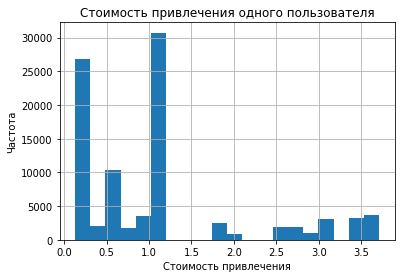

In [75]:
profiles['acquisition_cost'].hist(bins=20)
plt.title('Cтоимость привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()

In [76]:
#расчитаем средний CAC 
cac_mean = pd.DataFrame()
cac_mean['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_mean.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Дороже всего - TipTop (средняя стоимость - 2.80), далее идет FaceBoom и AdNonSense (1.11 и 1.01 соответственно). Дешевле всего - LeapBob (0.21). Остальные каналы берут за пользователя от 0.22 до 0.72 у.е.

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

# 5.1 Проанализируйте общую окупаемость рекламы

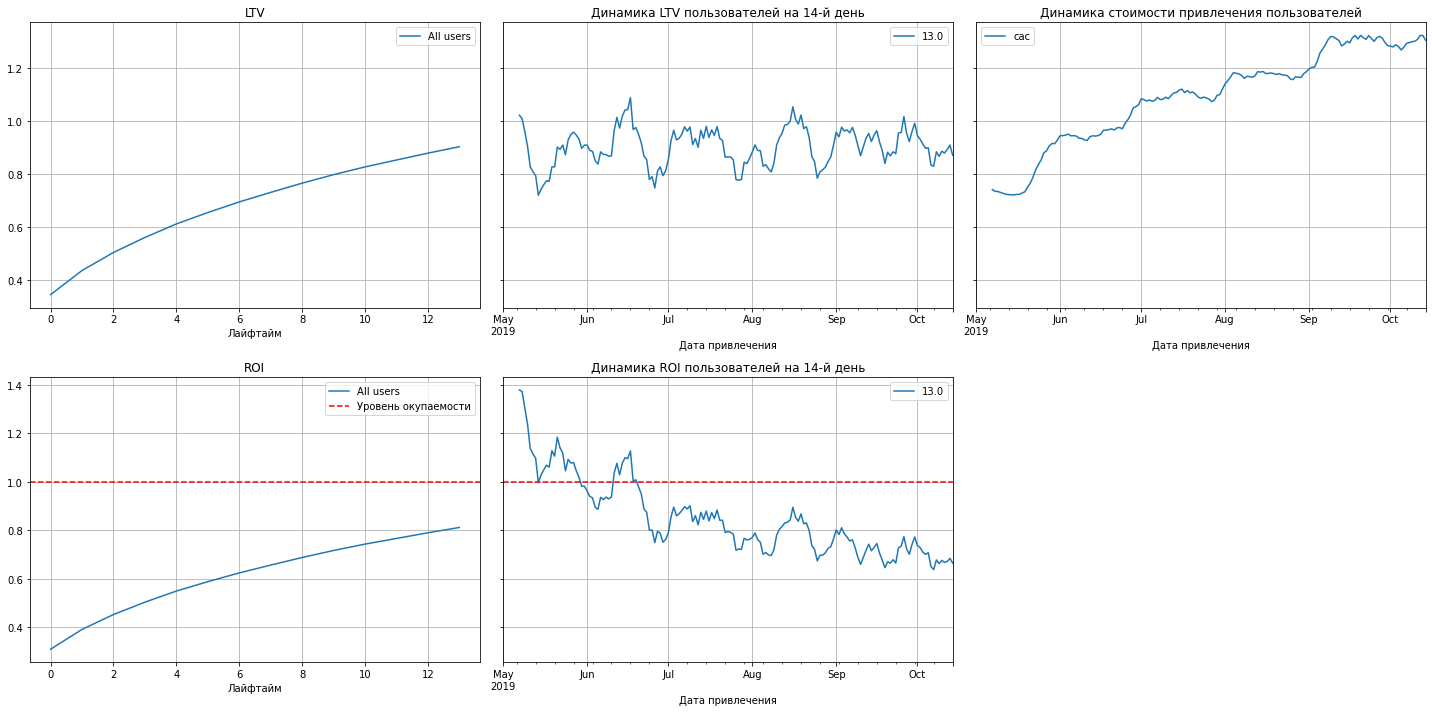

In [77]:
# Подсчитаем ROI и LTV
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) # построим графики

Судя по графикам:
- поскольку бюджет на рекламу увеличивается со временем, CAC не стабилен
- ROI постепенно падает, до июля держится выше окупаемости, а после падает вплоть до 0.6
- За 2 недели реклама не окупается, ROI приблизительно 80%
- LTV достаточно стабилен

# 5.2 Проанализируйте окупаемость рекламы с разбивкой по устройствам;

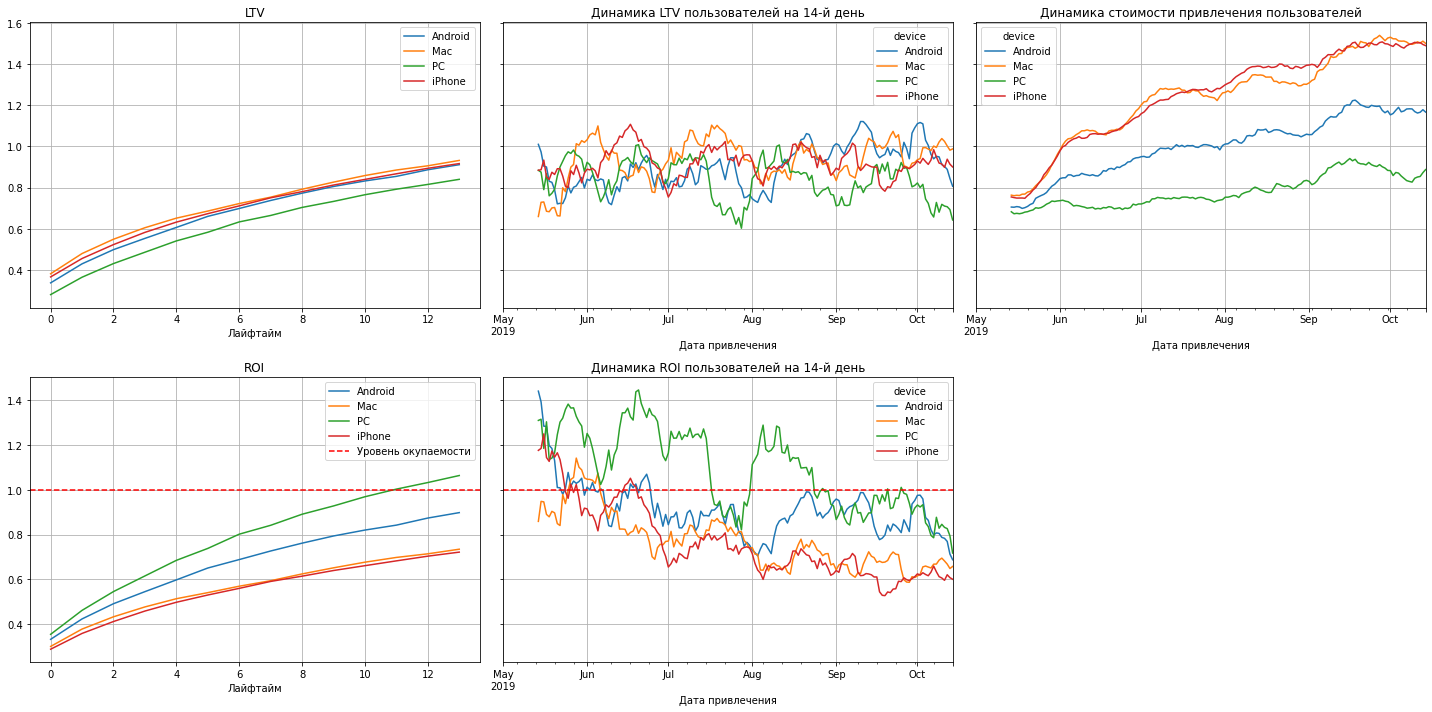

In [78]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Судя по графикам:
- Все устройства окупались до июня, затем окупаемость начала падать, сильнее всего для  Iphone и Mac. ROI PC какое-то время держался на грани окупаемости, в то время как отсльные сутройства продолжали падать. LTV пользователей всё так же стабилен. У PC самая низкая стоимость привлечения, при этом у всех платформ стоимость постепенно растет.
- Стоит внимательней рассмотреть Iphone и Mac поскольку у них плохая окупаемость, но при этом стоимость привлечения постепенно растет

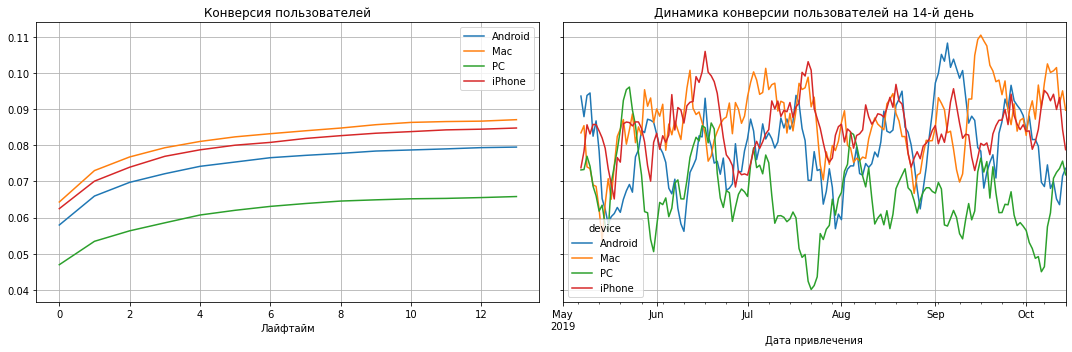

In [79]:
# рассмотрим конверсию по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам хуже всех конверируется PC, остальные платформы сильно не отличаются

In [80]:
# дополним функцию для расчёта удержания

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False,
):
    # добавляем платящих в список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не вошедших в интервал
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_cm']
    ).dt.days

    # строим функция для группировки таблицы
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # таблица удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # таблица динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # получаем сырые данные и обе таблицы
    return result_raw, result_grouped, result_in_time 

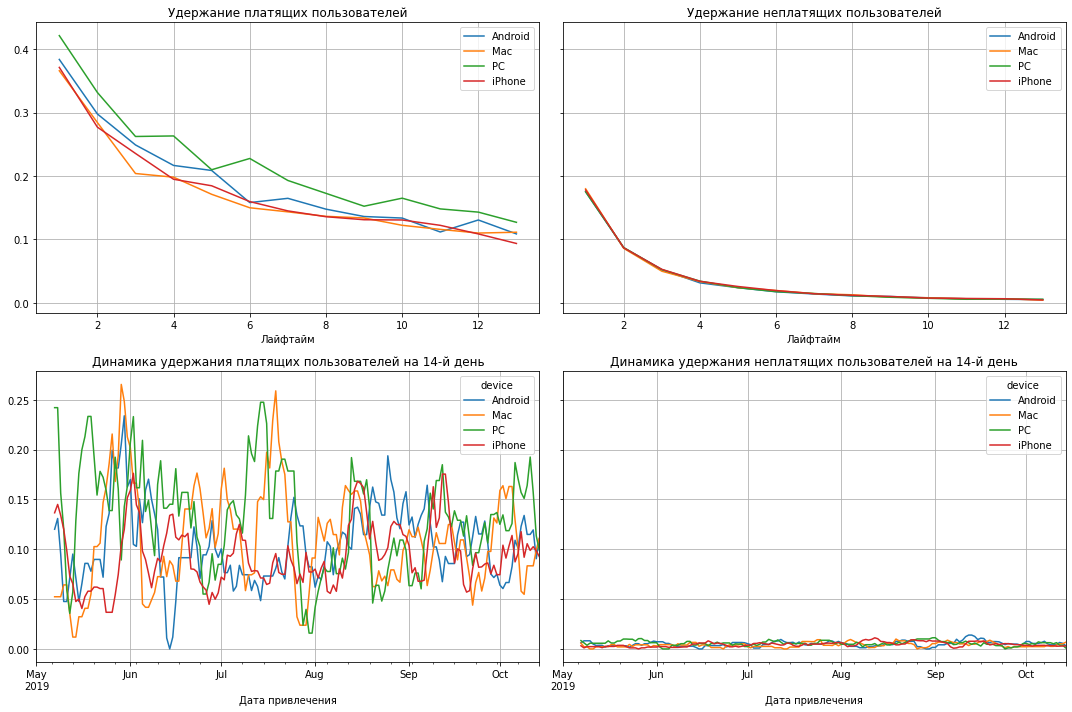

In [81]:
# построим графики удержания
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По удержанию платящих пользователй ни одна платформа сильно не выделяется, а с неплатящими пользователями удержание по всем платформам плохое 

# 5.3 Проанализируйте окупаемость рекламы с разбивкой по странам

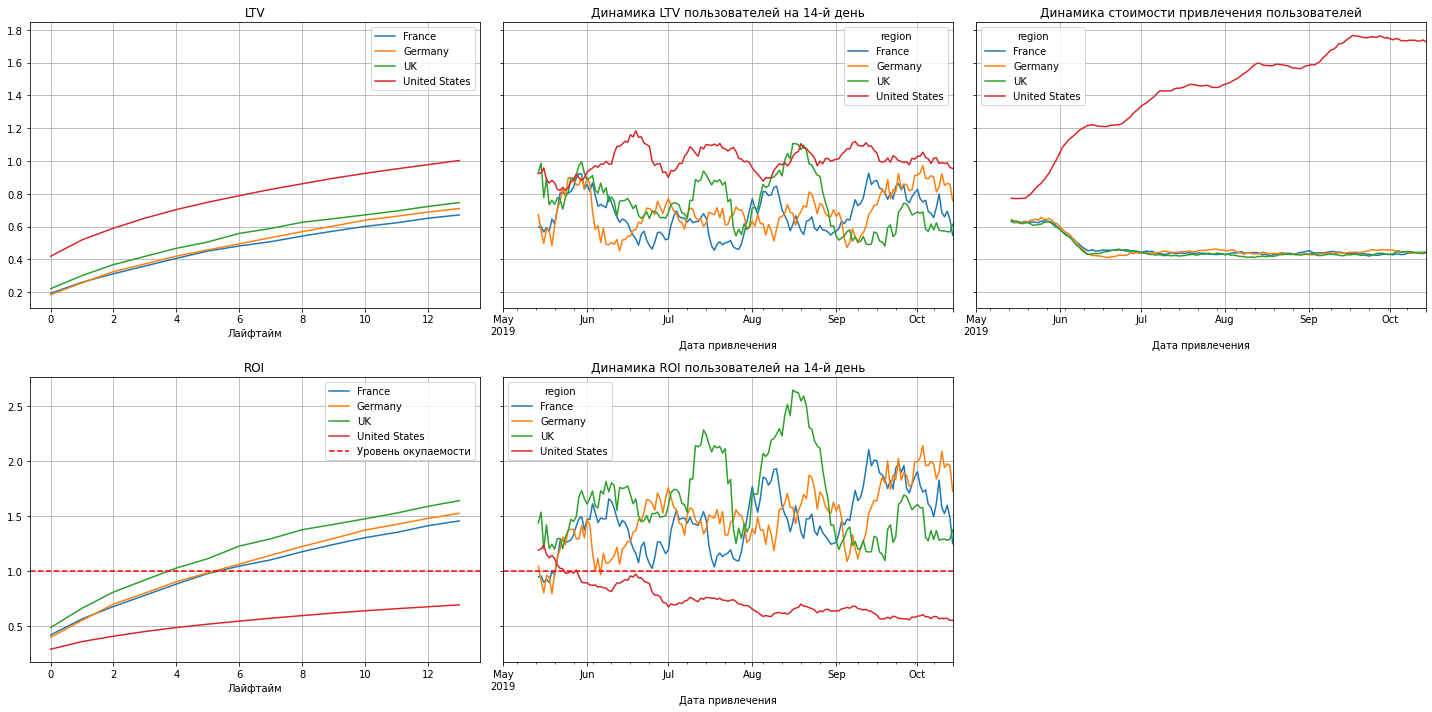

In [82]:
# строим графики окупаемости по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


Судя по графикам:
- Сильно выделяется стоимость привлечения пользователей из США, она намного выше других стран и при этом в отличии от них постепенно растет
- При этом в США самый низкий уровень окупаемости рекламы
- Лучшие показатели окупаемости у Германии и Англии 
- LTV также стабилен

Проанализируем проблемы с США

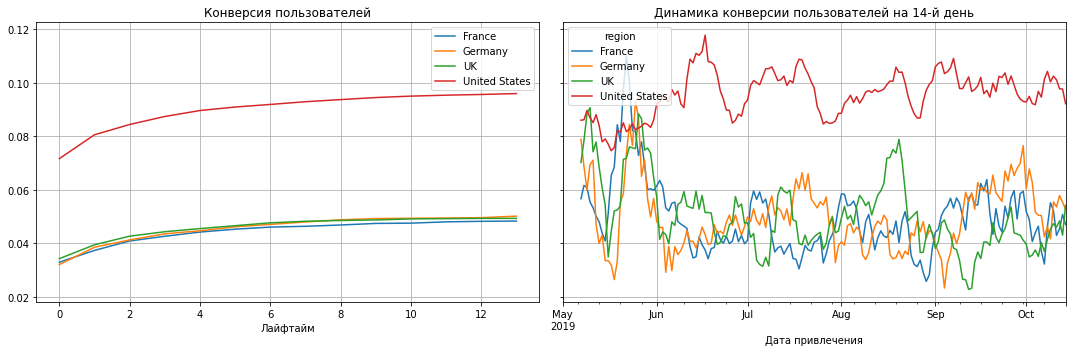

In [83]:
# строим графики конверсии по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Значительно выше всех конверсия у США

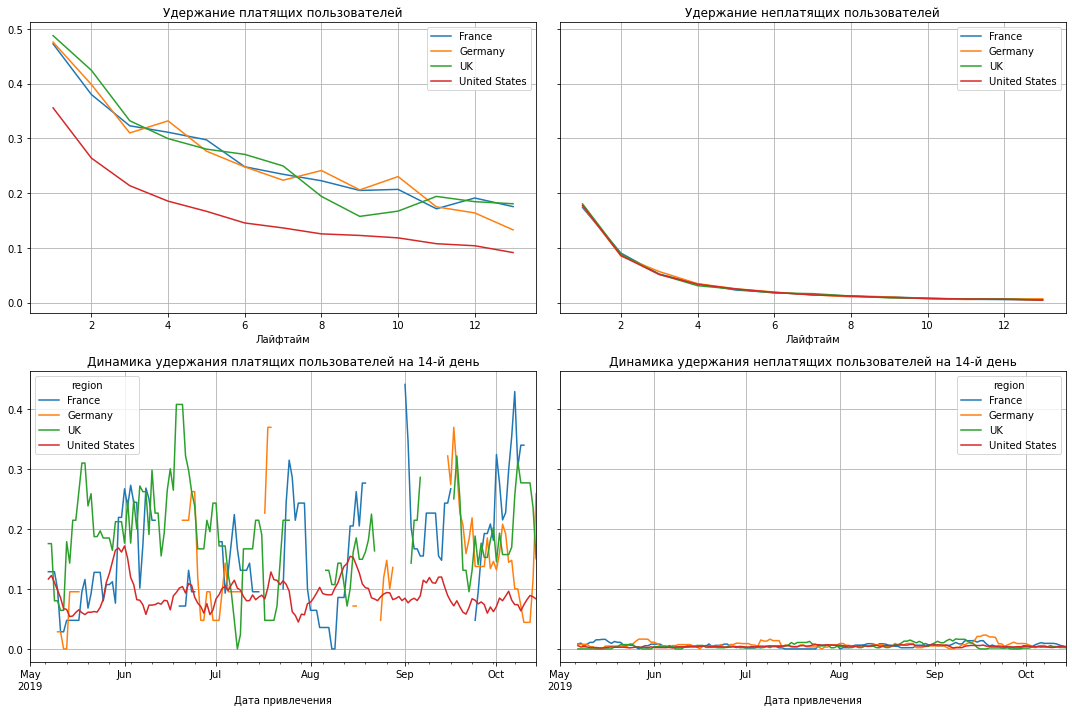

In [84]:
# строим графики удержания по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(retention_grouped, retention_history, horizon_days) 

Удержания пользователей из США значительно хуже других стран

# 5.4 Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

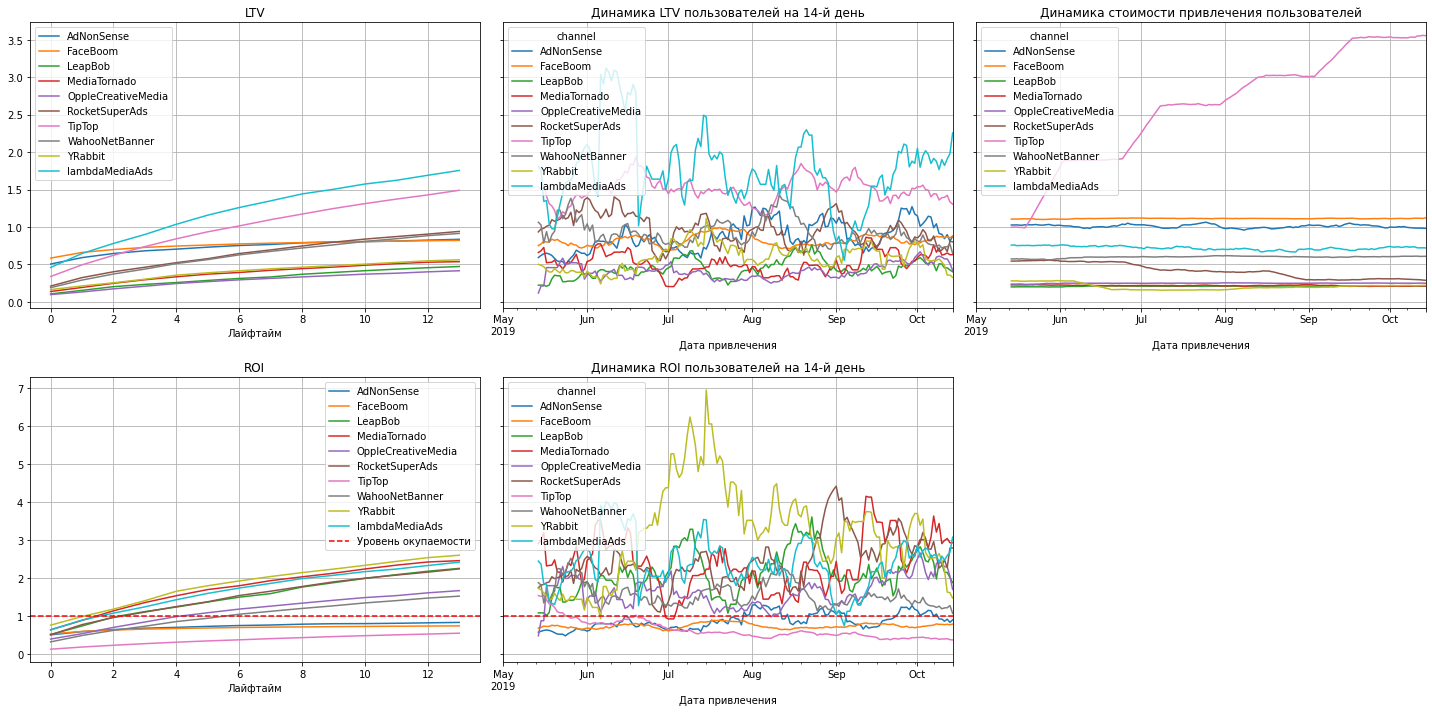

In [85]:
# строим графики окупаемости по источникам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Судя по графикам:
- пользователе из источников : TipTop, LeapBop и FaceBoom не окупаются
- хороший показатель ROI в июле у YRabbit
- Болтште траты на TipTop при этом низкая окупаемость

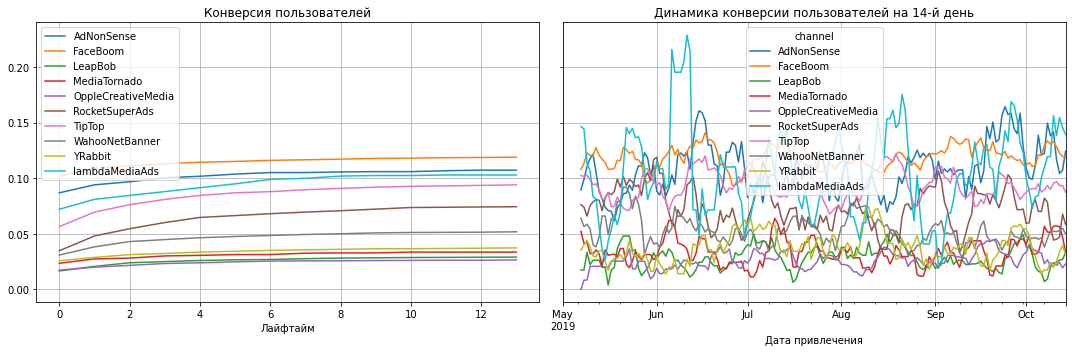

In [86]:
# строим графики конверсии по источникам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Плохая конверсия у пользователи из  YRabbit,MediaTornado и RocketSuperAds 

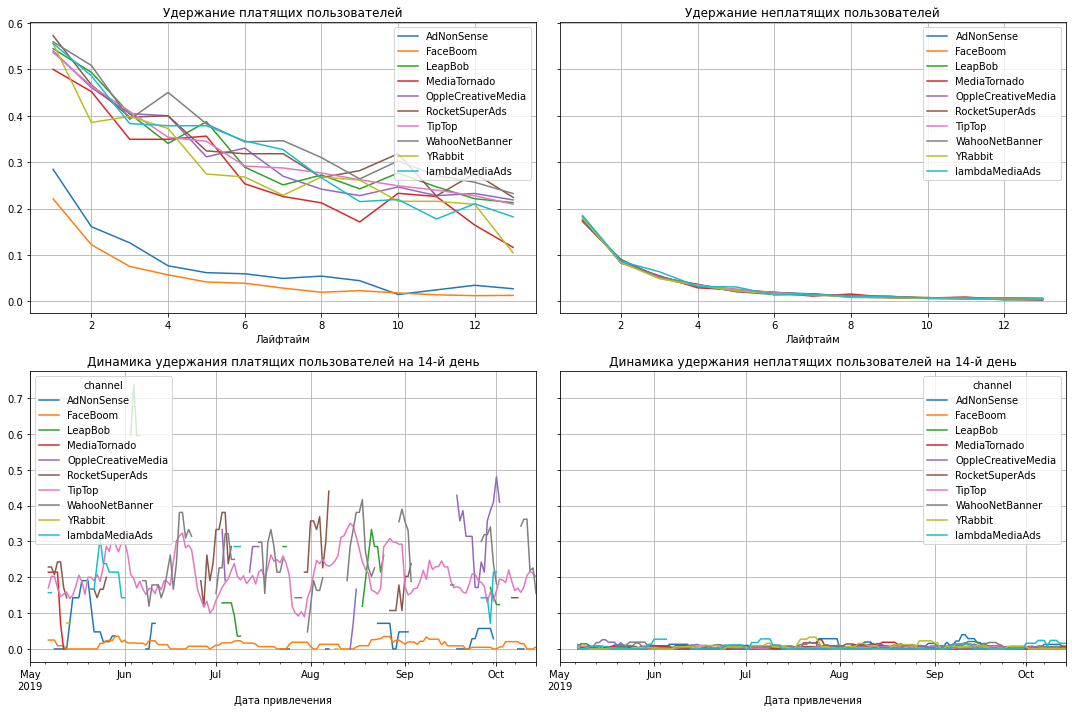

In [87]:
# строим графики удержания по источникам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Значительно хуже остальных показатели удержания у AdNonSense и FaceBoom.

## Шаг 6. Вывод

# 6.1 Причины неэффективности привлечения пользователей

Рассчитан и визуализирован ROI и LTV. Проведена оценка окупаемости рекламы
Выводы по графикам:
- поскольку бюджет на рекламу увеличивается со временем, CAC не стабилен
- ROI постепенно падает, до июля держится выше окупаемости, а после падает вплоть до 0.6
- За 2 недели реклама не окупается, ROI приблизительно 80%
- LTV достаточно стабилен

Разбивка по устройствам:
- Все устройства окупались до июня, затем окупаемость начала падать, сильнее всего для  Iphone и Mac. ROI PC какое-то время держался на грани окупаемости, в то время как отсльные сутройства продолжали падать. LTV пользователей всё так же стабилен. У PC самая низкая стоимость привлечения, при этом у всех платформ стоимость постепенно растет.
- Стоит внимательней рассмотреть Iphone и Mac поскольку у них плохая окупаемость, но при этом стоимость привлечения постепенно растет
- По удержанию платящих пользователй ни одна платформа сильно не выделяется, а с неплатящими пользователями удержание по всем платформам плохое

Разбивка по странам:
- Сильно выделяется стоимость привлечения пользователей из США, она намного выше других стран и при этом в отличии от них постепенно растет
- При этом в США самый низкий уровень окупаемости рекламы
- Лучшие показатели окупаемости у Германии и Англии 
- LTV также стабилен
- Значительно выше всех конверсия у США
- Удержания пользователей из США значительно хуже других стран

Разбивка по каналам:
- пользователи из источников : TipTop, LeapBop и FaceBoom не окупаются
- хороший показатель ROI в июле у YRabbit
- Большие траты на TipTop при этом низкая окупаемость
- Плохая конверсия у пользователи из  YRabbit,MediaTornado и RocketSuperAds
- Значительно хуже остальных показатели удержания у AdNonSense и FaceBoom.

# 6.2  Рекомендации для отдела маркетинга для повышения эффективности.

- В связи с большими тратами на TipTop и при этом отрицательной окупаемостью стоит перераспределить бюджет на боллее эффективные источники, например LambdaMediaAds и возможно отказаться от TipTop совсем. А также стоит рассмотреть различные соц.сети т.к. они имеют большой охват и при этом хорошую цену
- Поскольку лучшие показатели окупаемости у Германии и США стоит выделить больше средств на работу с этими регионами. А также разобраться в причине низкой окупаемости в США и возможна перевести часть средств с этого региона на ту же Германию и Англию.
- по устройствам стоит обратить свое внимание на Iphone и Mac при высокой и растущей стоимости привлечения эти платформы имеют плохие показатели окупаемости. Возможно стоит провести врменнуб акцию для этих платформ
- Стоит пересмотреть условия работы с TipTop, FaceBoom и LeapBop, поскольку пользователи из этих источников не окупаются
